<a href="https://www.kaggle.com/code/xannurov/baseline?scriptVersionId=162344278" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [12]:
data['hotel_address']

0                        Via Senigallia 6 20161 Milan Italy
1         Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2               Mallorca 251 Eixample 08008 Barcelona Spain
3         Piazza Della Repubblica 17 Central Station 201...
4         Singel 303 309 Amsterdam City Center 1012 WJ A...
                                ...                        
515733    9 Knaresborough Place Kensington and Chelsea L...
515734    Landstra er Hauptstra e 155 03 Landstra e 1030...
515735    29 31 Gower Street Camden London WC1E 6HG Unit...
515736    31 Great Cumberland Place Westminster Borough ...
515737    25 Courtfield Gardens Kensington and Chelsea L...
Name: hotel_address, Length: 515738, dtype: object

In [13]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [14]:
text = 'Afghanistan,Albania,Algeria,Andorra,Angola,Antigua & Deps,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Central African Rep,Chad,Chile,China,Colombia,Comoros,Congo,Congo {Democratic Rep},Costa Rica,Croatia,Cuba,Cyprus,Czech Republic,Denmark,Djibouti,Dominica,Dominican Republic,East Timor,Ecuador,Egypt,El Salvador,Equatorial Guinea,Eritrea,Estonia,Ethiopia,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Grenada,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland {Republic},Israel,Italy,Ivory Coast,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kiribati,Korea North,Korea South,Kosovo,Kuwait,Kyrgyzstan,Laos,Latvia,Lebanon,Lesotho,Liberia,Libya,Liechtenstein,Lithuania,Luxembourg,Macedonia,Madagascar,Malawi,Malaysia,Maldives,Mali,Malta,Marshall Islands,Mauritania,Mauritius,Mexico,Micronesia,Moldova,Monaco,Mongolia,Montenegro,Morocco,Mozambique,Myanmar, {Burma},Namibia,Nauru,Nepal,Netherlands,New Zealand,Nicaragua,Niger,Nigeria,Norway,Oman,Pakistan,Palau,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Romania,Russian Federation,Rwanda,St Kitts & Nevis,St Lucia,Saint Vincent & the Grenadines,Samoa,San Marino,Sao Tome & Principe,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Swaziland,Sweden,Switzerland,Syria,Taiwan,Tajikistan,Tanzania,Thailand,Togo,Tonga,Trinidad & Tobago,Tunisia,Turkey,Turkmenistan,Tuvalu,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Vatican City,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe'

In [15]:
city_names = ['Dublin', 'Riyadh', 'Ha Long', 'Madrid', 'Venice', 'Moscow', 'Orlando', 'Athens', 'Cairo', 'Berlin', 'Cancun', 'Jaipur', 'Johor Bahru', 'Vienna', 'Chennai', 'Milan', 'Las Vegas', 'Barcelona', 'Denpasar', 'Ho Chi Minh City', 'Shanghai', 'Los Angeles', 'Osaka', 'Miami', 'Agra', 'Amsterdam', 'Seoul', 'Medina', 'Prague', 'Guangzhou', 'Mecca', 'Taipei', 'Pattaya', 'Tokyo', 'Rome', 'Phuket', 'Mumbai', 'Shenzhen', 'Antalya', 'Delhi', 'Istanbul', 'Kuala Lumpur', 'New York City', 'Dubai', 'Paris', 'Macau', 'London', 'Bangkok', 'Hong Kong']

In [16]:
import re

def find_city(text):
    city_list = city_names  # Список известных городов для демонстрации

    for city in city_list:
        if city in text:
            return city
    return None

In [17]:
data['city'] = data['hotel_address'].apply(find_city)

In [18]:
from sklearn.preprocessing import LabelEncoder

# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Преобразование категориальной переменной
encoded_city = label_encoder.fit_transform(data['city'])

# Вывод преобразованных значений
print(encoded_city)

[3 0 1 ... 2 2 2]


In [19]:
data['city'] = encoded_city

In [20]:
countries_list = text.split(",")

print(countries_list)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua & Deps', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Rep', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo {Democratic Rep}', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland {Republic}', 'Israel', 'Italy', 'Ivory Coast',

In [21]:
pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [22]:
import pycountry

# Функция для нахождения названия страны в тексте
def find_country(text):
    for country in pycountry.countries:
        if country.name in text:
            return country.name

# Проходим по каждой строке в столбце 'hotel_address' и находим название страны
for index, row in data.iterrows():
    country_name = find_country(row['hotel_address'])
    if country_name:
        data.at[index, 'hotel_address'] = country_name

In [23]:

from sklearn.preprocessing import LabelEncoder




# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Преобразование категориальной переменной
encoded_values_national = label_encoder.fit_transform(data['reviewer_nationality'])

# Вывод преобразованных значений
print(encoded_values_national)

[214  22 196 ... 144 213  14]


In [24]:


# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Преобразование категориальной переменной
encoded_values = label_encoder.fit_transform(data['hotel_address'])

# Вывод преобразованных значений
print(encoded_values)

[2 3 4 ... 5 5 5]


In [25]:
import re

def extract_number(text):
    match = re.search(r'\d+', text)
    if match:
        return int(match.group())
    return None

number = extract_number("days_since_review")

In [26]:
data['days_since_review'] = data['days_since_review'].apply(extract_number)

In [27]:
data['country'] = encoded_values
data['national'] = encoded_values_national

In [28]:
data['lat'] = data['lat'].fillna(0, inplace=True)
data['lng'] = data['lng'].fillna(0, inplace=True)

In [29]:
# Преобразуем столбец 'review_date' в тип datetime
data['review_date'] = pd.to_datetime(data['review_date'])

# Извлекаем месяц и год
data['month'] = data['review_date'].dt.month
data['year'] = data['review_date'].dt.year

In [30]:
data = data.drop(['review_date'],axis = 1)
data = data.drop(['hotel_address'],axis = 1)
data = data.drop(['reviewer_nationality'],axis = 1)
data = data.drop(['year'],axis = 1)
data = data.drop(['country'],axis = 1)

In [31]:
data.nunique(dropna=False)

additional_number_of_scoring                     480
average_score                                     34
hotel_name                                      1492
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                                1
lng                                                1
sample                                             2
reviewer_score                                    38
city                                               7
national                                         227
month                                             12
dtype: int64

<AxesSubplot:>

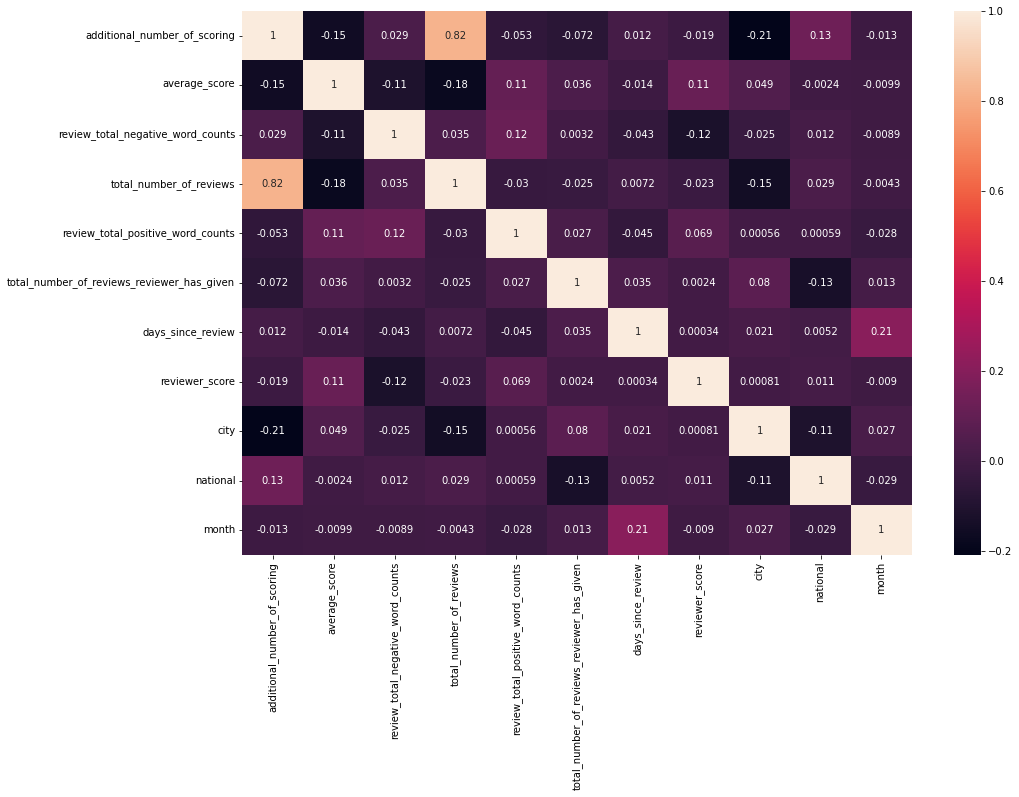

In [32]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [33]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   city                                        515738 non-null  int64  
 

In [35]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [36]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [37]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 11), (386803, 11), (386803, 10), (309442, 10), (77361, 10))

In [38]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [39]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [40]:
test_data

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,city,national,month
0,904,8.1,52,16670,62,1,13,0.0,3,214,7
1,612,8.6,10,5018,0,7,234,0.0,0,22,12
2,46,8.3,3,351,5,15,616,0.0,1,196,11
3,241,9.1,0,1543,27,9,656,0.0,3,216,10
4,834,9.1,0,4687,7,2,444,0.0,0,214,5
...,...,...,...,...,...,...,...,...,...,...,...
128930,53,8.1,0,984,4,14,547,0.0,3,81,2
128931,46,7.8,0,523,24,1,411,0.0,1,216,6
128932,260,8.0,31,3461,23,1,28,0.0,6,146,7
128933,159,9.0,0,1053,20,7,586,0.0,3,14,12


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   city                                        515738 non-null  int64  
 

In [42]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [43]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.946055148512139


<AxesSubplot:>

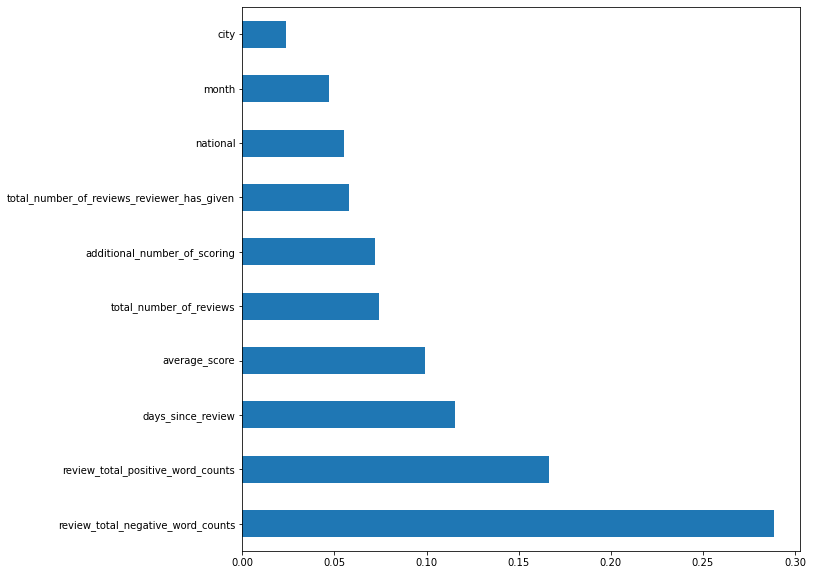

In [44]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [45]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,city,national,month
59333,757,8.7,0,5236,9,1,436,0.0,0,214,5
59376,806,7.8,16,3117,16,13,597,0.0,2,214,12
117878,206,9.3,89,1398,10,2,461,0.0,1,214,4
83001,995,8.1,0,3826,16,5,620,0.0,2,214,11
79063,48,9.0,0,361,32,2,78,0.0,0,214,5
106351,396,8.3,0,4293,61,1,115,0.0,1,214,4
79953,247,8.6,0,4026,18,2,406,0.0,6,14,6
22619,1485,7.5,9,6977,6,1,285,0.0,2,94,10
94611,147,9.1,11,975,10,9,555,0.0,2,176,1
44013,601,8.5,8,4032,8,20,178,0.0,0,216,2


In [46]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [47]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [48]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [49]:
predict_submission

array([8.166, 6.814, 7.725, ..., 8.062, 9.263, 7.126])

In [50]:
list(sample_submission)

['reviewer_score', 'id']

In [51]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.166,488440
1,6.814,274649
2,7.725,374688
3,9.263,404352
4,9.595,451596
5,8.947,302161
6,8.229,317079
7,7.908,13963
8,8.605,159785
9,8.285,195089


In [52]:
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.946055148512139


<AxesSubplot:>

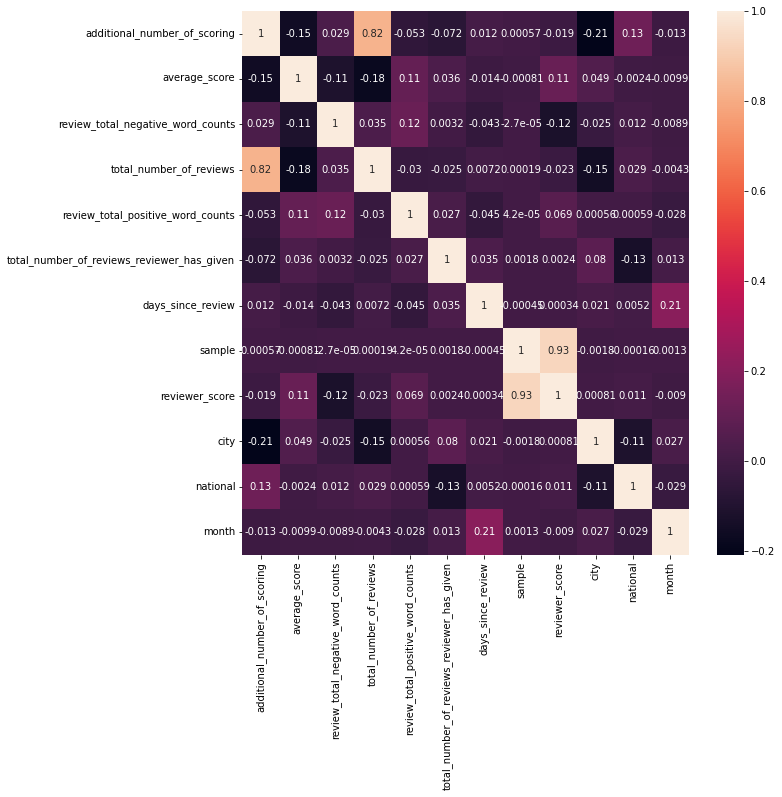

In [53]:
sns.heatmap(data.corr(),annot = True)